In [1]:
import os
import time
import random
import math
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from PIL import Image
from IPython.display import clear_output

import ai2thor
import ai2thor_colab
from ai2thor_colab import plot_frames
from ai2thor.controller import Controller

from ai2thor.platform import CloudRendering
controller = Controller(platform=CloudRendering)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [3]:
from network import DQN
from utils import to_torchdim, frame2tensor, plot_durations, encode_feedback

In [4]:
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
MEMORY_SIZE = int(1e4) # experience memory/buffer
BATCH_SIZE = 64
GAMMA = 0.999 # discounted return
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 20e3
TARGET_UPDATE = 2 # hard update

## Set Environment

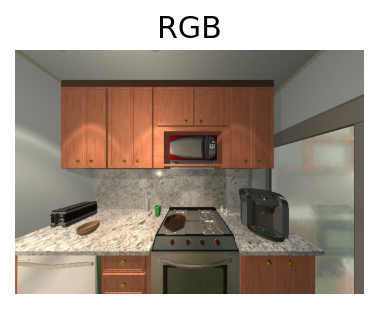

In [7]:
floor_index = random.randint(0, 30)
floor_index = 10

controller = Controller(
    agentMode = "default", # arm
    visibilityDistance = 1.5,
    scene = f"FloorPlan{floor_index}",

    # step sizes
    snapToGrid = True,
    gridSize = 0.25,
    rotateStepDegrees = 90,

    # image modalities
    renderInstanceSegmentation = False,
    renderDepthImage = False,
    renderSemanticSegmentation = False,
    renderNormalsImage = False,
    
    # camera properties
    width = 600,
    height = 420,
    fieldOfView = 120,
)

plot_frames(controller.last_event)

In [8]:
# action_space = ["MoveAhead", "MoveLeft", "MoveRight", "MoveBack", "RotateLeft", "RotateRight"]
action_space = ["MoveAhead", "MoveBack", "RotateLeft", "RotateRight"]

In [9]:
data = controller.last_event.metadata['objects']
object_space = [item['name'] for item in data]

## Set Replay Memory

In [10]:
Transition = namedtuple('Transition', 
                       ('state', 'action', 'reward', 'next_state'))

In [11]:
# a method for selecting a random batch of transitions for training
class ReplayMemory(object):
    """Fixed-size memory to store experience tuples."""
    
    def __init__(self, capacity):
        
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    # *args filled by state, action, next_state and reward variables
    def push(self, *args):
        """Add a new experience to memory."""
        
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        """Randomly sample a batch of experiences from memory."""
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [12]:
memory = ReplayMemory(MEMORY_SIZE) # init capacity

## Initialize DQN

In [13]:
# get the height, width of the observation (image) and action size from the environment
# screen_width = controller.last_event.metadata["screenWidth"]
# screen_height = controller.last_event.metadata["screenHeight"]
screen_width = 100
screen_height = 100

n_actions = len(action_space)

In [14]:
dqn_net = DQN(screen_width, screen_height, n_actions).to(device)
target_net = DQN(screen_width, screen_height, n_actions).to(device)
target_net.load_state_dict(dqn_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=2592, out_features=4, bias=True)
)

## Set Optimizer

In [15]:
optimizer = optim.RMSprop(dqn_net.parameters())

## Train DQN

In [16]:
steps_done = 0

# this will select an action accordingly to an epsilon greedy policy
def select_action(state):
    
    global steps_done
    
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    print("--- eps_threshold")
    print(eps_threshold)
    
    print("--- steps_done")
    print(steps_done)
    
    # print("--- state[0,0].shape")
    # print(state[0,0].shape)

    # plt.imshow(state[0,0])
    # plt.show()
        
    if sample > eps_threshold:
        with torch.no_grad():
            # here the network will pick action with the larger expected reward
            print("--- dqn_net(state)")
            print(dqn_net(state))
            
            action = dqn_net(state).max(1)[1].view(1, 1)
            print("--- action IF")
            print(action)
            
            return action
    else:
        action = torch.tensor([[random.randrange(n_actions)]], dtype=torch.long, device=device)
        print("--- action ELSE")
        print(action)

        return action

In [17]:
# this function first samples a batch, concatenates all the tensors into a single one
# then computes Q(st, at) and V(st+1) = maxaQ(st+1, a), and combines them into our loss
def optimize_network():
    
    # this will skip the optimization process if there is no enough memory
    if len(memory) < BATCH_SIZE: return
    
    transitions = memory.sample(BATCH_SIZE)
    
    # this converts batch-array of transitions to transition of batch-arrays
    batch = Transition(*zip(*transitions))
    
    # compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), dtype=torch.uint8, device=device)
    non_final_next_states = torch.cat([state for state in batch.next_state if state is not None])
    
    # concatenate all states, actions and rewards on the batch
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # compute V(s_{t+1}) for all next states
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # compute Q target
    Q_target = reward_batch + (GAMMA * next_state_values)
    
    # get the expected Q values
    # the network computes Q(s_t) then will select the columns of actions (a) taken
    # The (a) is the actions which would've been taken for each batch state according to dqn_net
    Q_current = dqn_net(state_batch).gather(1, action_batch)
    
    # compute huber loss
    loss = F.smooth_l1_loss(Q_current, Q_target.unsqueeze(1))
    
    # TD error = TD target - current value 
    # target_net = target network (frozen)
    # dqn_net = policy network/current value
    
    # this will perform optimization for the network
    optimizer.zero_grad()
    loss.backward()
    for param in dqn_net.parameters():
        param.grad.data.clamp_(-1, 1)
    
    optimizer.step()

In [18]:
def train_network(num_episodes, max_time):

    for i_episode in range(1, num_episodes+1):
        
        print("--------------------------------------------------------- i_episode!")
        print(i_episode)
        
        # initialize the environment and state
        controller.reset(random=True)

        screen = controller.last_event.frame
        resized_screen = Image.fromarray(screen).resize((screen_width, screen_height))

        # print("--- resized_screen.size")
        # print(resized_screen.size)
        
        # plt.imshow(resized_screen)
        # plt.show()

        state = frame2tensor(to_torchdim(resized_screen)).to(torch.float32).to(device)
        
        # print("--- state[0,0].shape")
        # print(state[0,0].shape)
        
        # plt.imshow(state[0,2])
        # plt.show()
        
        total_score = 0
        
        for time_step in range(1, max_time+1):
            
            # select and perform an action using dqn network
            action = select_action(state)
            
            # continue 
            
            event = controller.step(action = action_space[action.item()])
            
            _, reward, done, _ = encode_feedback(event, controller, target_name="LightSwitch_bf8119ce")
            total_score += reward
            reward = torch.tensor([reward], device=device)

            if not done:
                screen = controller.last_event.frame
                resized_screen = Image.fromarray(screen).resize((screen_width, screen_height))
                
                next_state = frame2tensor(to_torchdim(resized_screen)).to(torch.float32).to(device)
            else:
                next_state = None

            # store the transition in memory
            memory.push(state, action, reward, next_state)

            # move to the next state
            state = next_state

            # perform one step of the optimization on the target network
            optimize_network()

            if done or time_step==max_time:
                plot_durations(total_score, i_episode, num_episodes)
                break

            # update the target network, copying all weights and biases in DQN
            if i_episode % TARGET_UPDATE == 0:
                print("--------------------------------------------------------- UPDATE!")
                target_net.load_state_dict(dqn_net.state_dict())

    if not os.path.exists('./agents/'): os.makedirs('./agents/')
    torch.save(dqn_net.state_dict(), f'./agents/AI2THOR_RL.pth')
    print('Training completed.')
    plt.ioff()
    plt.show()

In [ ]:
print('Training the network...')
train_network(num_episodes=1000, max_time=400)

--------------------------------------------------------- i_episode!
4
--- eps_threshold
0.8624353562370971
--- steps_done
905
--- action ELSE
tensor([[3]])
--------------------------------------------------------- UPDATE!
--- eps_threshold
0.8623947354848125
--- steps_done
906
--- action ELSE
tensor([[1]])
--------------------------------------------------------- UPDATE!
--- eps_threshold
0.8623541167635147
--- steps_done
907
--- action ELSE
tensor([[2]])
--------------------------------------------------------- UPDATE!
--- eps_threshold
0.8623135000731024
--- steps_done
908
--- action ELSE
tensor([[2]])
--------------------------------------------------------- UPDATE!
--- eps_threshold
0.8622728854134736
--- steps_done
909
--- action ELSE
tensor([[2]])
--------------------------------------------------------- UPDATE!
--- eps_threshold
0.8622322727845272
--- steps_done
910
--- action ELSE
tensor([[2]])
--------------------------------------------------------- UPDATE!
--- eps_threshold

## Check The Result!

In [ ]:
# load the weights of smart agent
dqn_net.load_state_dict(torch.load(f'./agents/AI2THOR_RL.pth'));

In [ ]:
num_episodes = 20
best_score = -np.inf

for i_episode in range(1, num_episodes+1):
    
    # initialize the environment and state
    controller.reset(random=True)

    screen = controller.last_event.frame
    resized_screen = Image.fromarray(screen).resize((screen_width, screen_height))

    state = frame2tensor(to_torchdim(resized_screen)).to(torch.float32).to(device)
    
    total_score = 0
    
    for time_step in range(1, 100):
        
        # select an action using the trained dqn network
        with torch.no_grad():
            action = dqn_net(state).max(1)[1].view(1, 1)
        
        clear_output(wait=True)
        
        print("Episode:", i_episode+1)
        print("Action:", time_step+1)
        if action_space[action.item()] == "RotateLeft" or action_space[action.item()] == "RotateRight":
            print("Action:\033[91m", action_space[action.item()])
        else:
            print("Action:\033[92m", action_space[action.item()])

        event = controller.step(action = action_space[action.item()])
        
        time.sleep(1)
            
        _, reward, done, _ = encode_feedback(event, controller, target_name="LightSwitch_887b121a")
            
        # observe a new state
        if not done:
            screen = controller.last_event.frame
            resized_screen = Image.fromarray(screen).resize((screen_width, screen_height))

            next_state = frame2tensor(to_torchdim(resized_screen)).to(torch.float32).to(device)
        else:
            next_state = None
                
        state = next_state
        total_score += reward
        if done:
            break
            
    if total_score > best_score: 
        best_score = total_score
        
    print(f'\rEpisode {i_episode}/{num_episodes}, Best Score: {best_score}', end='')  

In [ ]:
controller.stop()

In [ ]:
# Todo list
# 1. Modify DQN to align with AI2THOR not Gym ✅
# 2. Modify train_network to align with AI2THOR not Gym ✅
# 3. Design reward ✅
# 4. Change epsilon strategy ✅
# 5. Apply Random initialization

---